No GPU available, using the CPU instead.


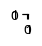

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

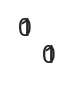

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


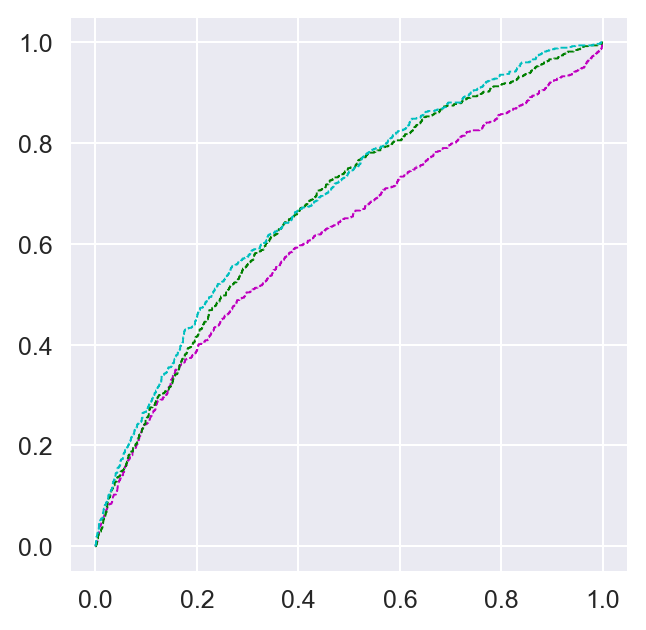

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

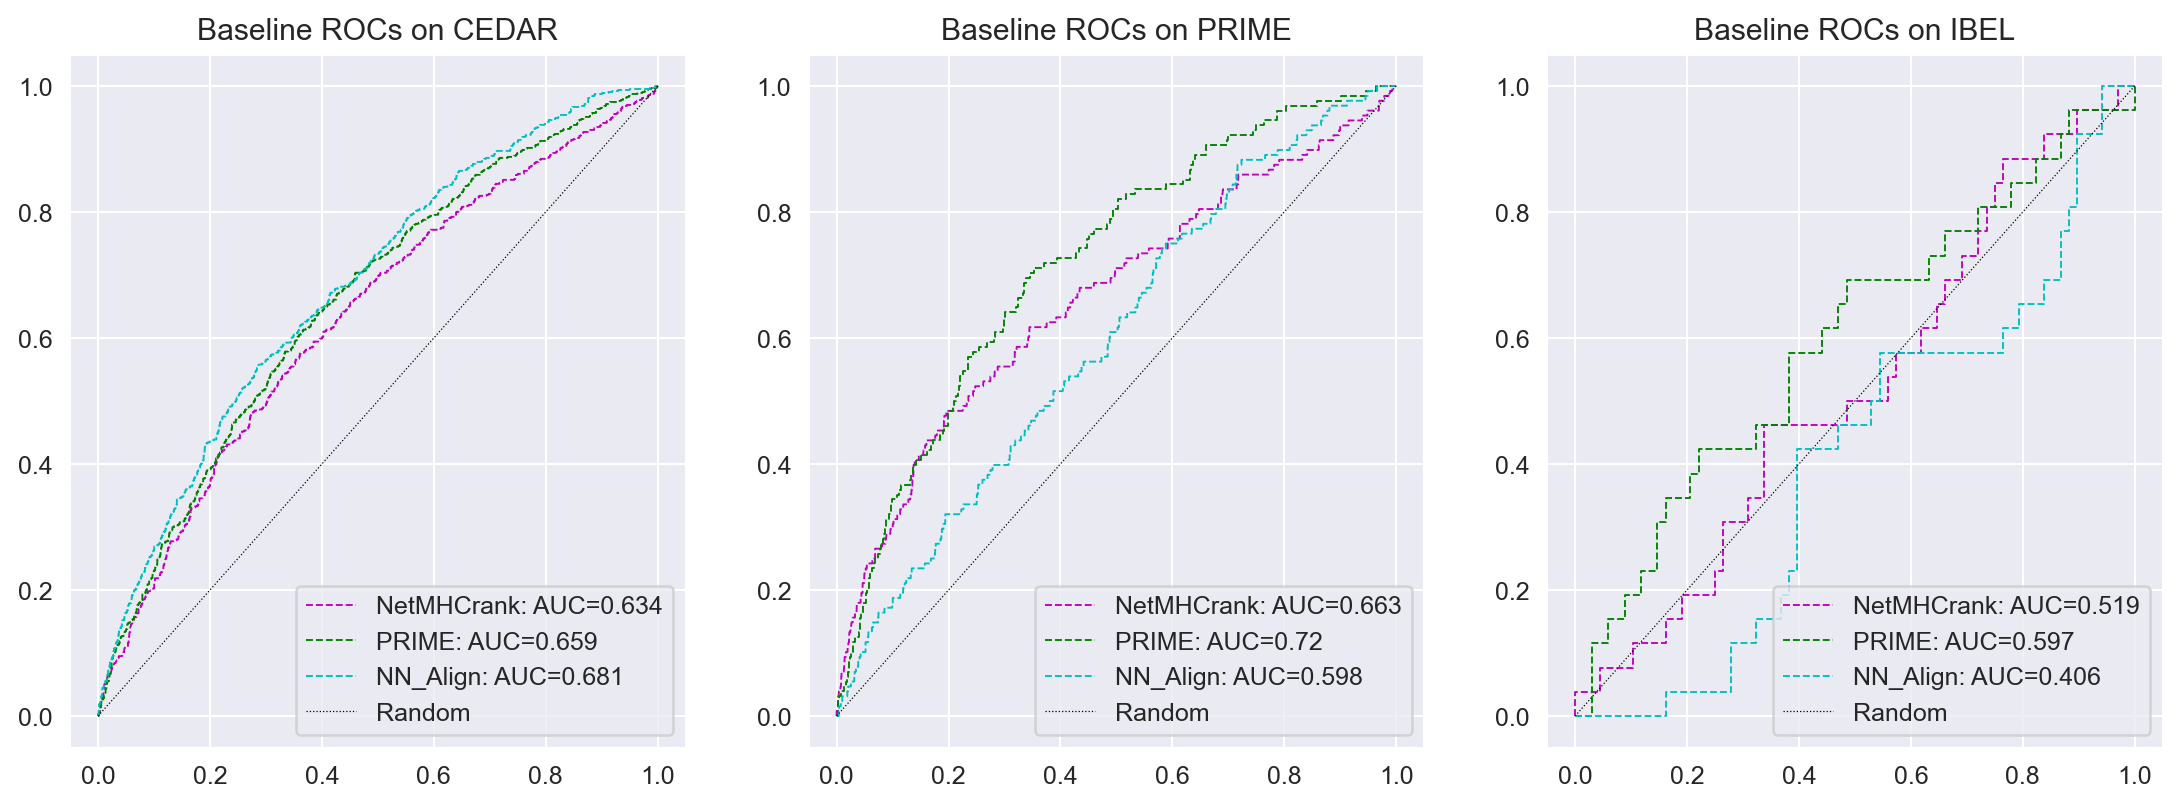

In [7]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

# results
need to do it in 6 different parts, but code should be the same

## Load-reshape-save

In [35]:
reshaped_dir = '../output/reshaped/'
cdt_cols = ['encoding', 'weight', 'pep_col', 'rank_col', 'key', 'trainset']

In [13]:
df_merged = pd.read_csv('../output/reshaped/221122_mutscore_merged_fixed_reshaped.csv').assign(trainset='merged').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                                                                                     mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                                                                                     mean_AP_cedar=('AP_cedar', 'mean'),
                                                                                                                                                     mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                                                                                     max_AUC_prime=('auc_prime', 'max'),
                                                                                                                                                     mean_AUC_prime=('auc_prime', 'mean'),
                                                                                                                                                     mean_AP_prime=('AP_prime', 'mean'),
                                                                                                                                                     mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                                                                                     max_AUC_ibel=('auc_ibel', 'max'),
                                                                                                                                                     mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                                                                                     mean_AP_ibel=('AP_ibel', 'mean'),
                                                                                                                                                     mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                                                                                     max_AUC_merged=('auc_merged', 'max'),
                                                                                                                                                  mean_AUC_merged=('auc_merged', 'mean'),
                                                                                                                                                  mean_AP_merged=('AP_merged', 'mean'),
                                                                                                                                                  mean_PRAUC_merged=('prauc_merged', 'mean'),
                                                                                                                                                     max_AUC_primeac=('auc_primeac', 'max'),
                                                                                                                                                     mean_AUC_primeac=('auc_primeac', 'mean'),
                                                                                                                                                     mean_AP_primeac=('AP_primeac', 'mean'),
                                                                                                                                                     mean_PRAUC_primeac=('prauc_primeac', 'mean'))

df_cedar = pd.read_csv('../output/reshaped/221122_mutscore_cedar_fixed_reshaped.csv').assign(trainset='cedar').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                                                                                  mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                                                                                  mean_AP_cedar=('AP_cedar', 'mean'),
                                                                                                                                                  mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                                                                                  max_AUC_prime=('auc_prime', 'max'),
                                                                                                                                                  mean_AUC_prime=('auc_prime', 'mean'),
                                                                                                                                                  mean_AP_prime=('AP_prime', 'mean'),
                                                                                                                                                  mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                                                                                  max_AUC_ibel=('auc_ibel', 'max'),
                                                                                                                                                  mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                                                                                  mean_AP_ibel=('AP_ibel', 'mean'),
                                                                                                                                                  mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                                                                                  max_AUC_primeac=('auc_primeac', 'max'),
                                                                                                                                                  mean_AUC_primeac=('auc_primeac', 'mean'),
                                                                                                                                                  mean_AP_primeac=('AP_primeac', 'mean'),
                                                                                                                                                  mean_PRAUC_primeac=('prauc_primeac', 'mean'))

df_prime = pd.read_csv('../output/reshaped/221122_mutscore_prime_fixed_reshaped.csv').assign(trainset='prime').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                                                                                  mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                                                                                  mean_AP_cedar=('AP_cedar', 'mean'),
                                                                                                                                                  mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                                                                                  max_AUC_prime=('auc_prime', 'max'),
                                                                                                                                                  mean_AUC_prime=('auc_prime', 'mean'),
                                                                                                                                                  mean_AP_prime=('AP_prime', 'mean'),
                                                                                                                                                  mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                                                                                  max_AUC_ibel=('auc_ibel', 'max'),
                                                                                                                                                  mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                                                                                  mean_AP_ibel=('AP_ibel', 'mean'),
                                                                                                                                                  mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                                                                                  max_AUC_primeac=('auc_primeac', 'max'),
                                                                                                                                                  mean_AUC_primeac=('auc_primeac', 'mean'),
                                                                                                                                                  mean_AP_primeac=('AP_primeac', 'mean'),
                                                                                                                                                  mean_PRAUC_primeac=('prauc_primeac', 'mean'))

In [ ]:
pd.concat([df_merged, df_cedar, df_prime]).to_csv('../output/reshaped/df_reshaped_normal.csv', index=True)

In [36]:
df_normal = pd.read_csv('../output/reshaped/df_reshaped_normal.csv', index_col=cdt_cols)
del df_merged, df_cedar, df_prime

In [28]:
df_merged_maskc = pd.read_csv('../output/reshaped/221122_mutscore_merged_maskcysteine_reshaped.csv').assign(trainset='merged_maskC').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'), mean_AUC_cedar=('auc_cedar', 'mean'),
mean_AP_cedar=('AP_cedar', 'mean'),
mean_PRAUC_cedar=('prauc_cedar', 'mean'),
max_AUC_prime=('auc_prime', 'max'),
mean_AUC_prime=('auc_prime', 'mean'),
mean_AP_prime=('AP_prime', 'mean'),
mean_PRAUC_prime=('prauc_prime', 'mean'),
max_AUC_ibel=('auc_ibel', 'max'),
mean_AUC_ibel=('auc_ibel', 'mean'),
mean_AP_ibel=('AP_ibel', 'mean'),
mean_PRAUC_ibel=('prauc_ibel', 'mean'),
max_AUC_merged=('auc_merged', 'max'),
mean_AUC_merged=('auc_merged', 'mean'),
mean_AP_merged=('AP_merged', 'mean'),
mean_PRAUC_merged=('prauc_merged', 'mean'),
max_AUC_primeac=('auc_primeac', 'max'),
mean_AUC_primeac=('auc_primeac', 'mean'),
mean_PRAUC_primeac=('prauc_primeac', 'mean'),
mean_AP_primeac=('AP_primeac', 'mean'))


df_cedar_maskc = pd.read_csv('../output/reshaped/221122_mutscore_cedar_maskcysteine_reshaped.csv').assign(trainset='cedar_maskC').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'),
mean_AUC_cedar=('auc_cedar', 'mean'),
mean_AP_cedar=('AP_cedar', 'mean'),
mean_PRAUC_cedar=('prauc_cedar', 'mean'),
max_AUC_prime=('auc_prime', 'max'),
mean_AUC_prime=('auc_prime', 'mean'),
mean_AP_prime=('AP_prime', 'mean'),
mean_PRAUC_prime=('prauc_prime', 'mean'),
max_AUC_ibel=('auc_ibel', 'max'),
mean_AUC_ibel=('auc_ibel', 'mean'),
mean_AP_ibel=('AP_ibel', 'mean'),
mean_PRAUC_ibel=('prauc_ibel', 'mean'),
max_AUC_primeac=('auc_primeac', 'max'),
mean_AUC_primeac=('auc_primeac', 'mean'),
mean_PRAUC_primeac=('prauc_primeac', 'mean'),
mean_AP_primeac=('AP_primeac', 'mean'))

df_prime_maskc = pd.read_csv('../output/reshaped/221122_mutscore_prime_maskcysteine_reshaped.csv').assign(trainset='prime_maskC').groupby(cdt_cols+['trainset']).agg(max_AUC_cedar=('auc_cedar', 'max'),
mean_AUC_cedar=('auc_cedar', 'mean'),
mean_AP_cedar=('AP_cedar', 'mean'),
mean_PRAUC_cedar=('prauc_cedar', 'mean'),
max_AUC_prime=('auc_prime', 'max'),
mean_AUC_prime=('auc_prime', 'mean'),
mean_AP_prime=('AP_prime', 'mean'),
mean_PRAUC_prime=('prauc_prime', 'mean'),
max_AUC_ibel=('auc_ibel', 'max'),
mean_AUC_ibel=('auc_ibel', 'mean'),
mean_AP_ibel=('AP_ibel', 'mean'),
mean_PRAUC_ibel=('prauc_ibel', 'mean'),
max_AUC_primeac=('auc_primeac', 'max'),
mean_AUC_primeac=('auc_primeac', 'mean'),
mean_PRAUC_primeac=('prauc_primeac', 'mean'),
mean_AP_primeac=('AP_primeac', 'mean'))

In [ ]:
pd.concat([df_merged_maskc, df_cedar_maskc, df_prime_maskc]).to_csv('../output/reshaped/df_reshaped_maskc.csv')

del df_merged_maskc, df_cedar_maskc, df_prime_maskc

In [39]:
df_maskc = pd.read_csv('../output/reshaped/df_reshaped_maskc.csv', index_col=cdt_cols)

## reshape indx

In [277]:
weight_map={'None':'None',
             'Inverted KL':'IC KL',
             'Inverted Shannon': 'IC Shannon',
             'Inverted Mask' : 'IC Mask',
             'KL' : '(1-IC) KL',
            'Shannon':'(1-IC) Shannon',
            'Mask':'(1-IC) Mask'}

weight_invmap = {k:v for v,k in weight_map.items()}
    
def map_weight(name):
    if name in weight_map.keys():
        return weight_map[name]
    else:
        return name
    
def invmap_weight(name):
    if name in weight_invmap.keys():
        return weight_invmap[name]
    else:
        return name     
    

def top25(df, trainset, evalset):
    return df.query("trainset==@trainset").sort_values(f'mean_AUC_{evalset}', ascending=False).head(25)

def get_topname(top_df):
    top_name = list(top_df.head(1).index.item())
    # Assumes weight name has been converted to IC/1-IC x
    top_name[1] = invmap_weight(top_name[1])
    top_name[1] = '-'.join(top_name[1].split(' '))
    return '_'.join(top_name[:-1])

def get_topname_parse(top_df):
    top_name = list(top_df.head(1).index.item())
    # Here doesn't rename the weight because we want to query with it
    return 'XX'.join(top_name[:-1])

from IPython.core.display import display, HTML
def display_top(top_df, n=15):
    output = top_df[auc_cols].head(n).to_html(formatters={col: '{:,.2%}'.format for col in auc_cols})
    display(HTML(output))
    
def get_count(top_df, evalset):
    tmp_feats = top_df.reset_index('key').groupby('key').agg(x=(f'mean_AUC_{evalset}','count'))
    tmp_weight = top_df.reset_index('weight').groupby('weight').agg(x=(f'mean_AUC_{evalset}','count'))
    feat_counts={}
    idx=list(tmp_feats.index)
    vals=tmp_feats.x.values
    for k,v in zip(idx,vals):
        names = k.split('-')
        for n in names:
            if n in feat_counts.keys():
                feat_counts[n]+=v
            else:
                feat_counts[n]=v
    print('feats', feat_counts)
    
    weight_counts={}
    idx=list(tmp_weight.index)
    vals=tmp_weight.x.values
    for k,v in zip(idx,vals):
        if k in weight_counts.keys():
            weight_counts[k]+=v
        else:
            weight_counts[k]=v
    print('weight', weight_counts)
    return feat_counts, weight_counts

In [84]:
df_normal.reset_index(inplace=True)
df_maskc.reset_index(inplace=True)
df_normal['weight'] = df_normal['weight'].apply(map_weight)
df_maskc['weight'] = df_maskc['weight'].apply(map_weight)
df_normal.set_index(cdt_cols, inplace=True)
df_maskc.set_index(cdt_cols, inplace=True)

In [94]:
df_normal['mean_AUC_agg'] = 0.5*(df_normal['mean_AUC_cedar']+df_normal['mean_AUC_prime'])
df_maskc['mean_AUC_agg'] = 0.5*(df_maskc['mean_AUC_cedar']+df_maskc['mean_AUC_prime'])

In [97]:
auc_cols = list(filter(lambda x : 'auc' in x.lower() and 'PR' not in x and 'mean' in x, df_normal.columns))
auc_cols

['mean_AUC_cedar',
 'mean_AUC_prime',
 'mean_AUC_ibel',
 'mean_AUC_merged',
 'mean_AUC_primeac',
 'mean_AUC_agg']

## gb_agg checks

Naming conventions : 

- top25_trainset_evalset

- Define "agg" as 50% CEDAR / 50% PRIME mean AUC

- def **map_weight(name):**

- def **invmap_weight(name):**

- def **get_topname(top_df):**

- def **top25(df, trainset, evalset):**

- def **display_top(top_df, n=15):**

- def **get_count(top_df, evalset):**


### hurr durr caveman coding to download files with bash script matching wildcards hurrrr

In [186]:
# Make script to rsync best files for normal
dir_ = '../output/best_conditions/sh/'
os.makedirs(dir_, exist_ok=True)
for trainset in ['cedar', 'prime', 'merged']:
    for evalset in ['cedar', 'prime', 'ibel', 'agg', 'primeac', 'merged']:
        if evalset=='merged' and trainset != 'merged': continue
        with open(f'{dir_}train-{trainset}_eval-{evalset}.sh', 'w') as f:
            f.write('#! /usr/bin/bash\n')
            topname = get_topname(top25(df_normal, trainset, evalset))
            f.write(f'mkdir ../{trainset}\n')
            f.write(f'cd ../{trainset}\n')
            f.write(f'rsync -auv --include="*/" --include="*{topname}*" --exclude="*" --exclude="*{topname}-" yatwan@ssh.computerome.dk:/home/projects/vaccine/people/yatwan/cedar/output/221122_mutscore_{trainset}_fixed/ "./best_{evalset}/" --progress\n')
            f.write(f'cd ./best_{evalset}\n')
            f.write(f'rm ./raw/*preds*\n')
            f.write(f'rm ./bootstrapping/*bootstrapped_df*\n')
            f.write(f'mv ./raw/* ./\n')
            f.write(f'mv ./bootstrapping/* ./\n')
            f.write(f'rm *{topname}-*\n')
            f.write(f'rmdir bootstrapping\n')
            f.write(f'rmdir raw\n')
            f.write(f'touch {topname}')

In [189]:
# Make script to rsync best files for maskc
dir_ = '../output/best_conditions/sh_maskc/'
os.makedirs(dir_, exist_ok=True)
for trainset in ['cedar_maskC', 'prime_maskC', 'merged_maskC']:
    for evalset in ['cedar', 'prime', 'ibel', 'agg', 'primeac', 'merged']:
        if evalset=='merged' and trainset != 'merged': continue
        with open(f'{dir_}train-{trainset}_eval-{evalset}.sh', 'w') as f:
            f.write('#! /usr/bin/bash\n')
            topname = get_topname(top25(df_maskc, trainset, evalset))
            f.write(f'mkdir ../{trainset}\n')
            f.write(f'cd ../{trainset}\n')
            f.write(f'rsync -auv --include="*/" --include="*{topname}*" --exclude="*" --exclude="*{topname}-" yatwan@ssh.computerome.dk:/home/projects/vaccine/people/yatwan/cedar/output/221122_mutscore_{trainset.replace("_maskC","")}_maskcysteine/ "./best_{evalset}/" --progress\n')
            f.write(f'cd ./best_{evalset}\n')
            f.write(f'rm ./raw/*preds*\n')
            f.write(f'rm ./bootstrapping/*bootstrapped_df*\n')
            f.write(f'mv ./raw/* ./\n')
            f.write(f'mv ./bootstrapping/* ./\n')
            f.write(f'rm *{topname}-*\n')
            f.write(f'rmdir bootstrapping\n')
            f.write(f'rmdir raw\n')
            f.write(f'touch {topname}')

### Overall

In [241]:
pd.concat([df_normal.reset_index('trainset').query('trainset=="prime"').assign(trainset='prime').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols],
           df_normal.reset_index('trainset').query('trainset=="cedar"').assign(trainset='cedar').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols],
           df_normal.reset_index('trainset').query('trainset=="merged"').assign(trainset='merged').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="prime_maskC"').assign(trainset='prime_maskC').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="cedar_maskC"').assign(trainset='cedar_maskC').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="merged_maskC"').assign(trainset='merged_maskC').sort_values('mean_AUC_cedar', ascending=False).head(1)[['trainset']+auc_cols]])

trainset  \
encoding weight      pep_col   rank_col    key                                                
onehot   (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score         prime   
         IC KL       Peptide   EL_rank_mut aa_props                                   cedar   
                                           aa_props                                  merged   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                       prime_maskC   
         IC Shannon  icore_mut EL_rank_mut aa_props                             cedar_maskC   
                                           aa_props                            merged_maskC   

                                                                               mean_AUC_cedar  \
encoding weight      pep_col   rank_col    key                                                  
onehot   (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score        0.673219   
         IC KL       Peptide   EL_rank_mut aa_props                                  0.727865   
                                           aa_props                                  0.728261   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                            0.677151   
         IC Shannon  icore_mut EL_rank_mut aa_props                                  0.723525   
                                           aa_props                                  0.721187   

                                                                               mean_AUC_prime  \
encoding weight      pep_col   rank_col    key                                                  
onehot   (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score        0.672768   
         IC KL       Peptide   EL_rank_mut aa_props                                  0.654859   
                                           aa_props                                  0.687674   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                            0.672089   
         IC Shannon  icore_mut EL_rank_mut aa_props                                  0.635517   
                                           aa_props                                  0.674823   

                                                                               mean_AUC_ibel  \
encoding weight      pep_col   rank_col    key                                                 
onehot   (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score       0.536425   
         IC KL       Peptide   EL_rank_mut aa_props                                 0.538541   
                                           aa_props                                 0.558946   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                           0.559566   
         IC Shannon  icore_mut EL_rank_mut aa_props                                 0.535304   
                                           aa_props                                 0.573206   

                                                                               mean_AUC_merged  \
encoding weight      pep_col   rank_col    key                                                   
onehot   (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score              NaN   
         IC KL       Peptide   EL_rank_mut aa_props                                        NaN   
                                           aa_props                                   0.723580   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                                  NaN   
         IC Shannon  icore_mut EL_rank_mut aa_props                                        NaN   
                                           aa_props                                   0.722222   

                                                                               mean_AUC_primeac  \
encoding weight      pep_col   rank_col    key                                                    
onehot   (1-IC) 

In [254]:
comparison = ('onehot', '(1-IC) Mask', 'Peptide', 'EL_rank_mut', 'blsm_mut_score')
pd.concat([df_normal.loc[comparison][auc_cols],
df_maskc.loc[comparison][auc_cols]])

,mean_AUC_cedar,mean_AUC_prime,mean_AUC_ibel,mean_AUC_merged,mean_AUC_primeac,mean_AUC_agg
trainset,,,,,,
merged,0.704501,0.720973,0.593015,0.710781,0.748716,0.712737
cedar,0.700055,0.711472,0.593410,NaN,0.723794,0.705763
prime,0.662763,0.692050,0.557306,NaN,0.740558,0.677407
merged_maskC,0.704910,0.722694,0.592429,0.711507,0.751889,0.713802
cedar_maskC,0.700038,0.711653,0.596873,NaN,0.727071,0.705846
prime_maskC,0.667532,0.685107,0.580373,NaN,0.745389,0.676320


In [251]:
df_maskc.reset_index(('weight', 'trainset')).query('trainset=="prime_maskC" and weight=="IC KL"')[['weight', 'trainset']+auc_cols].sort_values('mean_AUC_primeac', ascending=False)

weight  \
encoding pep_col   rank_col    key                                                         
onehot   Peptide   EL_rank_mut aa_props                                            IC KL   
                               mutation_score-ratio_rank                           IC KL   
                               dissimilarity_score-blsm_mut_score-mutation_sco...  IC KL   
                               ratio_rank                                          IC KL   
                               core_mutation_score-ratio_rank                      IC KL   
...                                                                                  ...   
BL62FREQ icore_mut EL_rank_mut core_blsm_mut_score-core_mutation_score             IC KL   
                               core_blsm_mut_score                                 IC KL   
                               core_mutation_score                                 IC KL   
                               blsm_mut_score                                      IC KL   
                               only_rank                                           IC KL   

                                                                                      trainset  \
encoding pep_col   rank_col    key                                                               
onehot   Peptide   EL_rank_mut aa_props                                            prime_maskC   
                               mutation_score-ratio_rank                           prime_maskC   
                               dissimilarity_score-blsm_mut_score-mutation_sco...  prime_maskC   
                               ratio_rank                                          prime_maskC   
                               core_mutation_score-ratio_rank                      prime_maskC   
...                                                                                        ...   
BL62FREQ icore_mut EL_rank_mut core_blsm_mut_score-core_mutation_score             prime_maskC   
                               core_blsm_mut_score                                 prime_maskC   
                               core_mutation_score                                 prime_maskC   
                               blsm_mut_score                                      prime_maskC   
                               only_rank                                           prime_maskC   

                                                                                   mean_AUC_cedar  \
encoding pep_col   rank_col    key                                                                  
onehot   Peptide   EL_rank_mut aa_props                                                  0.645521   
                               mutation_score-ratio_rank                                 0.627081   
                               dissimilarity_score-blsm_mut_score-mutation_sco...        0.633259   
                               ratio_rank                                                0.624918   
                               core_mutation_score-ratio_rank                            0.623869   
...                                                                                           ...   
BL62FREQ icore_mut EL_rank_mut core_blsm_mut_score-core_mutation_score                   0.632978   
                               core_blsm_mut_score                                       0.634139   
                               core_mutation_score                                       0.631717   
                               blsm_mut_score                                            0.633364   
                               only_rank                                                 0.631374   

                                                                                   mean_AUC_prime  \
encoding pep_col   rank_col    key                                                                  
onehot   Peptide   EL_rank_mut aa_props                                                  0.623

In [248]:
df_normal.reset_index(('weight', 'trainset')).query('trainset=="prime" and weight=="IC KL"')[['weight', 'trainset']+auc_cols].sort_values('mean_AUC_primeac', ascending=False)

weight  \
encoding pep_col   rank_col        key                                              
onehot   Peptide   EL_rank_mut     aa_props                                 IC KL   
                                   mutation_score-ratio_rank                IC KL   
BL62LO   Peptide   EL_rank_mut     aa_props                                 IC KL   
onehot   Peptide   EL_rank_mut     ratio_rank                               IC KL   
                                   core_mutation_score-ratio_rank           IC KL   
...                                                                           ...   
BL62FREQ icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score  IC KL   
                                   core_blsm_mut_score                      IC KL   
                                   blsm_mut_score                           IC KL   
                                   core_blsm_mut_score-core_mutation_score  IC KL   
                   trueHLA_EL_rank core_blsm_mut_score-core_mutation_score  IC KL   

                                                                           trainset  \
encoding pep_col   rank_col        key                                                
onehot   Peptide   EL_rank_mut     aa_props                                   prime   
                                   mutation_score-ratio_rank                  prime   
BL62LO   Peptide   EL_rank_mut     aa_props                                   prime   
onehot   Peptide   EL_rank_mut     ratio_rank                                 prime   
                                   core_mutation_score-ratio_rank             prime   
...                                                                             ...   
BL62FREQ icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score    prime   
                                   core_blsm_mut_score                        prime   
                                   blsm_mut_score                             prime   
                                   core_blsm_mut_score-core_mutation_score    prime   
                   trueHLA_EL_rank core_blsm_mut_score-core_mutation_score    prime   

                                                                            mean_AUC_cedar  \
encoding pep_col   rank_col        key                                                       
onehot   Peptide   EL_rank_mut     aa_props                                       0.649882   
                                   mutation_score-ratio_rank                      0.631627   
BL62LO   Peptide   EL_rank_mut     aa_props                                       0.642672   
onehot   Peptide   EL_rank_mut     ratio_rank                                     0.630351   
                                   core_mutation_score-ratio_rank                 0.629501   
...                                                                                    ...   
BL62FREQ icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score        0.641006   
                                   core_blsm_mut_score                            0.634297   
                                   blsm_mut_score                                 0.634023   
                                   core_blsm_mut_score-core_mutation_score        0.634712   
                   trueHLA_EL_rank core_blsm_mut_score-core_mutation_score        0.636324   

                                                                            mean_AUC_prime  \
encoding pep_col   rank_col        key                                                       
onehot   Peptide   EL_rank_mut     aa_props                                       0.650461   
                                   mutation_score-ratio_rank                      0.658652   
BL62LO   Peptide   EL_rank_mut     aa_props                                       0.655511   
onehot   Peptide   EL_rank_mut     ratio_rank                                     0.657262   
                                   core_mutation_s

In [240]:
# Top1 PRIME for each trainset
pd.concat([df_normal.reset_index('trainset').query('trainset=="prime"').assign(trainset='prime').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols],
           df_normal.reset_index('trainset').query('trainset=="cedar"').assign(trainset='cedar').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols],
           df_normal.reset_index('trainset').query('trainset=="merged"').assign(trainset='merged').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="prime_maskC"').assign(trainset='prime_maskC').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="cedar_maskC"').assign(trainset='cedar_maskC').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols],
           df_maskc.reset_index('trainset').query('trainset=="merged_maskC"').assign(trainset='merged_maskC').sort_values('mean_AUC_prime', ascending=False).head(1)[['trainset']+auc_cols]])

trainset  \
encoding weight      pep_col rank_col    key                                                                
onehot   (1-IC) Mask Peptide EL_rank_mut blsm_mut_score                                             prime   
                                         core_blsm_mut_score-core_mutation_score                    cedar   
                                         dissimilarity_score-core_mutation_score                   merged   
BL62LO   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score-ratio_rank   prime_maskC   
onehot   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score              cedar_maskC   
                                         dissimilarity_score-core_mutation_score             merged_maskC   

                                                                                             mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                                  
onehot   (1-IC) Mask Peptide EL_rank_mut blsm_mut_score                                            0.662763   
                                         core_blsm_mut_score-core_mutation_score                   0.699172   
                                         dissimilarity_score-core_mutation_score                   0.700505   
BL62LO   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score-ratio_rank        0.657676   
onehot   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score                   0.699448   
                                         dissimilarity_score-core_mutation_score                   0.700527   

                                                                                             mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                                  
onehot   (1-IC) Mask Peptide EL_rank_mut blsm_mut_score                                            0.692050   
                                         core_blsm_mut_score-core_mutation_score                   0.715089   
                                         dissimilarity_score-core_mutation_score                   0.727528   
BL62LO   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score-ratio_rank        0.689481   
onehot   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score                   0.715212   
                                         dissimilarity_score-core_mutation_score                   0.726733   

                                                                                             mean_AUC_ibel  \
encoding weight      pep_col rank_col    key                                                                 
onehot   (1-IC) Mask Peptide EL_rank_mut blsm_mut_score                                           0.557306   
                                         core_blsm_mut_score-core_mutation_score                  0.585730   
                                         dissimilarity_score-core_mutation_score                  0.560951   
BL62LO   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score-ratio_rank       0.663444   
onehot   (1-IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score                  0.584029   
                                         dissimilarity_score-core_mutation_score                  0.565453   

                                                                                             mean_AUC_merged  \
encoding weight      pep_col rank_col    key                                                                   
onehot   (1-IC) Mask Peptide EL_rank_mut blsm_mut_score                                                  NaN   
                                         core_blsm_mut_score-core_mutation_score                         NaN   
                                         dissimilarity_score-core_mutation_score                    0.712399   
BL62L

### Normal 

#### Cedar as trainset ; Check all evalsets

In [170]:
top25_cedar_cedar = top25(df_normal, 'cedar', 'cedar')[auc_cols]
top25_cedar_prime = top25(df_normal, 'cedar', 'prime')[auc_cols]
top25_cedar_ibel = top25(df_normal, 'cedar', 'ibel')[auc_cols]
top25_cedar_agg = top25(df_normal, 'cedar', 'agg')[auc_cols]
top25_cedar_primeac = top25(df_normal, 'cedar', 'primeac')[auc_cols]

name_cedar_cedar = get_topname(top25_cedar_cedar)
name_cedar_prime = get_topname(top25_cedar_prime)
name_cedar_ibel = get_topname(top25_cedar_ibel)
name_cedar_agg = get_topname(top25_cedar_agg)
name_cedar_primeac = get_topname(top25_cedar_primeac)

In [160]:
print('TOP FOR top25_cedar_cedar')
feat_top25_cedar_cedar, weight_top25_cedar_cedar = get_count(top25_cedar_cedar, 'cedar')
display_top(top25_cedar_cedar, 5)
print('\n\n\nTOP FOR top25_cedar_prime')
feat_top25_cedar_prime, weight_top25_cedar_prime = get_count(top25_cedar_prime, 'prime')
display_top(top25_cedar_prime, 5)
print('\n\n\nTOP FOR top25_cedar_ibel')
feat_top25_cedar_ibel, weight_top25_cedar_ibel = get_count(top25_cedar_ibel, 'ibel')
display_top(top25_cedar_ibel, 5)

print('\n\n\nTOP FOR top25_cedar_primeac')
feat_top25_cedar_primeac, weight_top25_cedar_primeac = get_count(top25_cedar_primeac, 'primeac')
display_top(top25_cedar_primeac, 5)
print('\n\n\nTOP FOR top25_cedar_agg')
feat_top25_cedar_agg, weight_top25_cedar_agg = get_count(top25_cedar_agg, 'agg')
display_top(top25_cedar_agg, 5)


TOP FOR top25_cedar_cedar
feats {'aa_props': 8, 'blsm_mut_score': 7, 'mutation_score': 9, 'ratio_rank': 11, 'core_blsm_mut_score': 3, 'core_mutation_score': 2, 'dissimilarity_score': 6}
weight {'IC KL': 16, 'IC Shannon': 9}





TOP FOR top25_cedar_prime
feats {'blsm_mut_score': 7, 'mutation_score': 6, 'core_blsm_mut_score': 9, 'core_mutation_score': 9, 'dissimilarity_score': 12, 'only_rank': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_cedar_ibel
feats {'blsm_mut_score': 10, 'mutation_score': 10, 'core_blsm_mut_score': 6, 'core_mutation_score': 5, 'dissimilarity_score': 15, 'only_rank': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_cedar_primeac
feats {'blsm_mut_score': 5, 'mutation_score': 5, 'core_blsm_mut_score': 10, 'core_mutation_score': 12, 'dissimilarity_score': 16, 'only_rank': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_cedar_agg
feats {'blsm_mut_score': 8, 'mutation_score': 6, 'core_blsm_mut_score': 10, 'core_mutation_score': 9, 'dissimilarity_score': 13, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


#### Merged as trainset ; Check all evalsets

In [190]:
top25_merged_cedar = top25(df_normal, 'merged', 'cedar')[auc_cols]
top25_merged_prime = top25(df_normal, 'merged', 'prime')[auc_cols]
top25_merged_ibel = top25(df_normal, 'merged', 'ibel')[auc_cols]
top25_merged_merged = top25(df_normal, 'merged', 'merged')[auc_cols]
top25_merged_primeac = top25(df_normal, 'merged', 'primeac')[auc_cols]
top25_merged_agg = top25(df_normal, 'merged', 'agg')[auc_cols]


name_merged_cedar = get_topname(top25_merged_cedar)
name_merged_prime = get_topname(top25_merged_prime)
name_merged_merged = get_topname(top25_merged_merged)
name_merged_ibel = get_topname(top25_merged_ibel)
name_merged_agg = get_topname(top25_merged_agg)
name_merged_primeac = get_topname(top25_merged_primeac)

In [194]:
print('TOP FOR top25_merged_cedar')
feat_top25_merged_cedar, weight_top25_merged_cedar = get_count(top25_merged_cedar, 'cedar')
display_top(top25_merged_cedar, 5)

print('TOP FOR top25_merged_prime')
feat_top25_merged_prime, weight_top25_merged_prime = get_count(top25_merged_prime, 'prime')
display_top(top25_merged_prime, 5)

print('TOP FOR top25_merged_ibel')
feat_top25_merged_ibel, weight_top25_merged_ibel = get_count(top25_merged_ibel, 'ibel')
display_top(top25_merged_ibel, 5)

print('TOP FOR top25_merged_merged')
feat_top25_merged_merged, weight_top25_merged_merged = get_count(top25_merged_merged, 'merged')
display_top(top25_merged_merged, 5)

print('TOP FOR top25_merged_primeac')
feat_top25_merged_primeac, weight_top25_merged_primeac = get_count(top25_merged_primeac, 'primeac')
display_top(top25_merged_primeac, 5)

print('TOP FOR top25_merged_agg')
feat_top25_merged_agg, weight_top25_merged_agg = get_count(top25_merged_agg, 'agg')
display_top(top25_merged_agg, 5)


TOP FOR top25_merged_cedar
feats {'aa_props': 11, 'blsm_mut_score': 7, 'mutation_score': 6, 'core_blsm_mut_score': 2, 'dissimilarity_score': 4, 'only_rank': 2}
weight {'IC KL': 12, 'IC Shannon': 13}


TOP FOR top25_merged_prime
feats {'blsm_mut_score': 8, 'mutation_score': 6, 'core_blsm_mut_score': 8, 'core_mutation_score': 9, 'dissimilarity_score': 13, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


TOP FOR top25_merged_ibel
feats {'blsm_mut_score': 12, 'mutation_score': 8, 'core_blsm_mut_score': 7, 'core_mutation_score': 4, 'dissimilarity_score': 13, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


TOP FOR top25_merged_merged
feats {'core_blsm_mut_score': 25, 'core_mutation_score': 16, 'ratio_rank': 25, 'dissimilarity_score': 7}
weight {'(1-IC) KL': 2, '(1-IC) Mask': 1, '(1-IC) Shannon': 4, 'IC KL': 2, 'IC Mask': 7, 'IC Shannon': 4, 'None': 5}


TOP FOR top25_merged_primeac
feats {'blsm_mut_score': 8, 'mutation_score': 7, 'core_blsm_mut_score': 8, 'core_mutation_score': 12, 'dissimilarity_score': 19}
weight {'(1-IC) KL': 5, '(1-IC) Mask': 14, '(1-IC) Shannon': 6}


TOP FOR top25_merged_agg
feats {'blsm_mut_score': 8, 'mutation_score': 5, 'core_blsm_mut_score': 12, 'core_mutation_score': 10, 'dissimilarity_score': 14}
weight {'(1-IC) KL': 1, '(1-IC) Mask': 21, '(1-IC) Shannon': 2, 'IC Mask': 1}


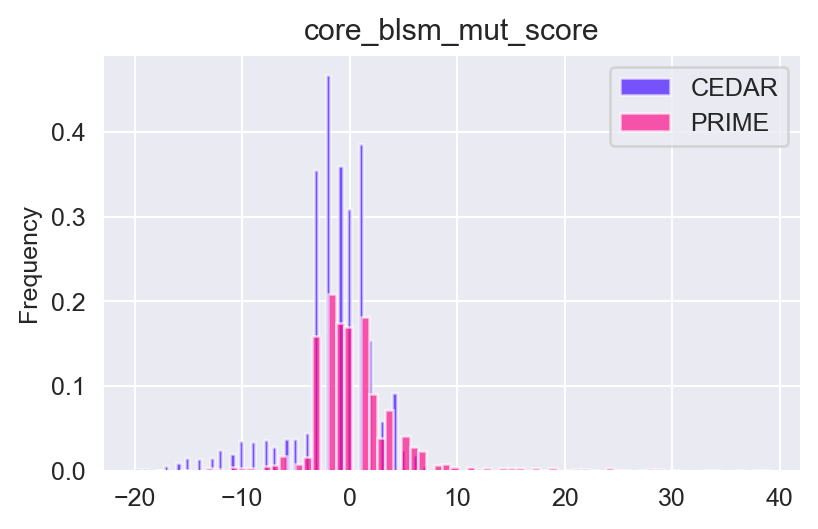

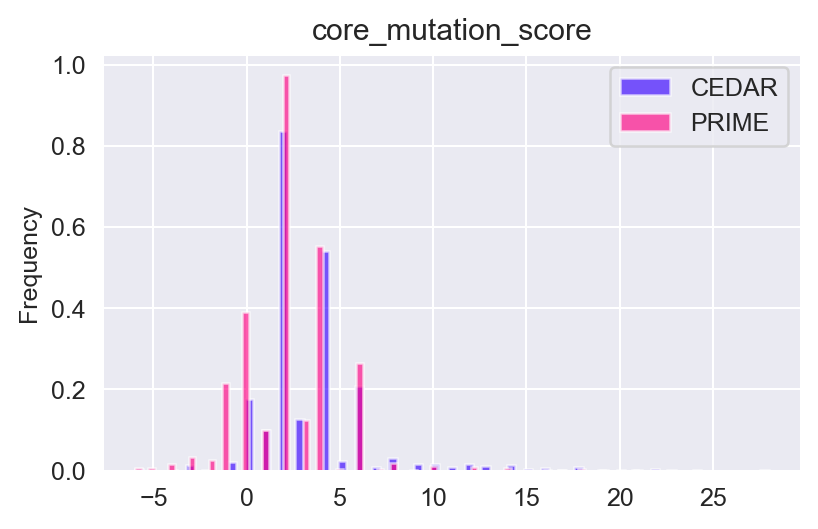

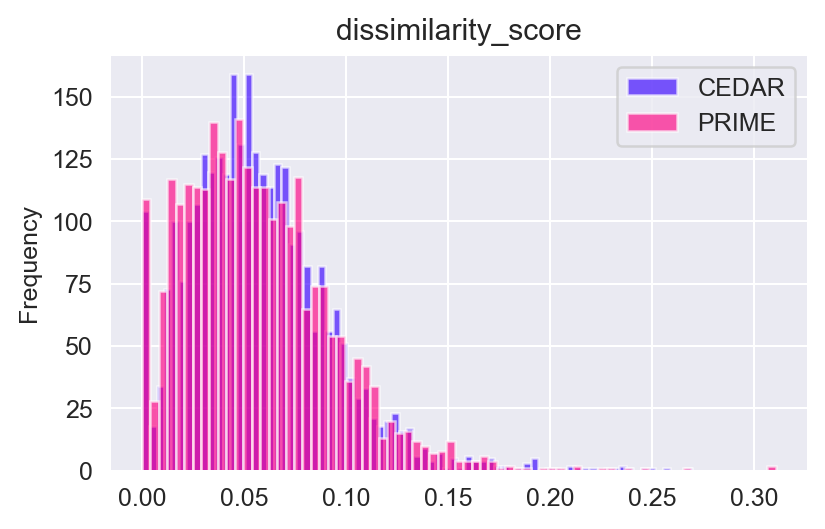

In [361]:
#TOP FOR top25_merged_primeac
#feats {'core_blsm_mut_score': 25, 'core_mutation_score': 16, 'ratio_rank': 25, 'dissimilarity_score': 7}
#weight {'(1-IC) KL': 2, '(1-IC) Mask': 1, '(1-IC) Shannon': 4, 'IC KL': 2, 'IC Mask': 7, 'IC Shannon': 4, 'None': 5}
sns.set_palette(HSV)
for feat in {'core_blsm_mut_score': 25, 'core_mutation_score': 16, 'dissimilarity_score': 7}.keys():
    f,a = plt.subplots(1,1,figsize=(5,3))
    dens = 'mut' in feat 
    merged.groupby('dataset')[feat].plot(kind='hist',density=dens,bins=75, legend=True, alpha=0.65, ax=a)
    if feat=='ratio_rank':
        a.set_xlim([0,100])
    a.set_title(feat)
    

In [380]:
30/0.3541

84.72182999152781

In [386]:
prime_related['ratio_rank']=prime_related['EL_rank_wt']/prime_related['EL_rank_mut']
merged['ratio_rank']=merged['EL_rank_wt']/merged['EL_rank_mut']

Text(0.5, 1.0, 'ratio_rank')

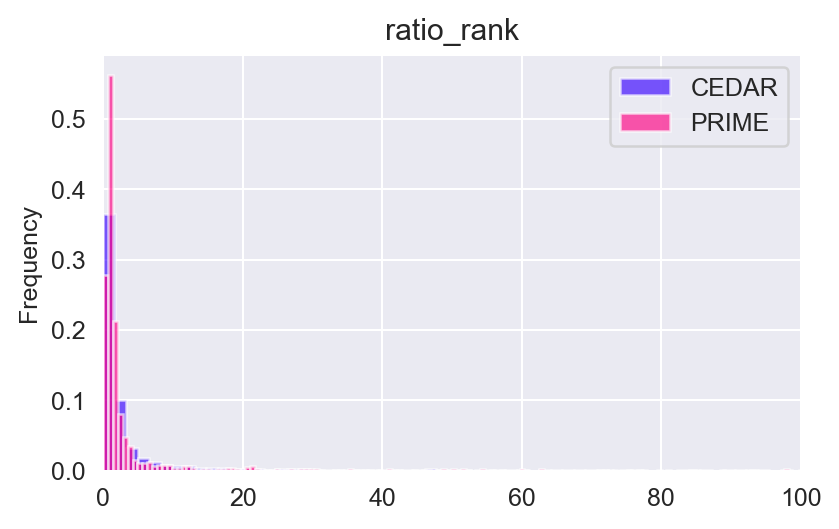

In [394]:
feat = 'ratio_rank'

f,a = plt.subplots(1,1,figsize=(5,3))
merged.groupby('dataset')[feat].plot(kind='hist',density=True,bins=1000, legend=True, alpha=0.65, ax=a)
a.set_xlim([0,100])
a.set_title(feat)

#### prime ast trainset ; check all evalsets

In [193]:
top25_prime_cedar = top25(df_normal, 'prime', 'cedar')[auc_cols]
top25_prime_prime = top25(df_normal, 'prime', 'prime')[auc_cols]
top25_prime_ibel = top25(df_normal, 'prime', 'ibel')[auc_cols]
top25_prime_agg = top25(df_normal, 'prime', 'agg')[auc_cols]
top25_prime_primeac = top25(df_normal, 'prime', 'primeac')[auc_cols]



name_prime_cedar = get_topname(top25_prime_cedar)
name_prime_prime = get_topname(top25_prime_prime)
name_prime_ibel = get_topname(top25_prime_ibel)
name_prime_agg = get_topname(top25_prime_agg)
name_prime_primeac = get_topname(top25_prime_primeac)

In [197]:
print('\n\n\nTOP FOR top25_prime_cedar')
feat_top25_prime_cedar, weight_top25_prime_cedar = get_count(top25_prime_cedar, 'cedar')
display_top(top25_prime_cedar, 5)

print('\n\n\nTOP FOR top25_prime_prime')
feat_top25_prime_prime, weight_top25_prime_prime = get_count(top25_prime_prime, 'prime')
display_top(top25_prime_prime, 5)

print('\n\n\nTOP FOR top25_prime_ibel')
feat_top25_prime_ibel, weight_top25_prime_ibel = get_count(top25_prime_ibel, 'ibel')
display_top(top25_prime_ibel, 5)



print('\n\n\nTOP FOR top25_prime_primeac')
feat_top25_prime_primeac, weight_top25_prime_primeac = get_count(top25_prime_primeac, 'primeac')
display_top(top25_prime_primeac, 5)

print('\n\n\nTOP FOR top25_prime_agg')
feat_top25_prime_agg, weight_top25_prime_agg = get_count(top25_prime_agg, 'agg')
display_top(top25_prime_agg, 5)





TOP FOR top25_prime_cedar
feats {'blsm_mut_score': 15, 'mutation_score': 7, 'ratio_rank': 9, 'core_blsm_mut_score': 6, 'core_mutation_score': 3, 'dissimilarity_score': 15}
weight {'(1-IC) Mask': 25}





TOP FOR top25_prime_prime
feats {'blsm_mut_score': 10, 'mutation_score': 18, 'ratio_rank': 15, 'core_blsm_mut_score': 3, 'core_mutation_score': 2, 'dissimilarity_score': 8, 'only_rank': 1}
weight {'(1-IC) Mask': 17, 'IC Mask': 5, 'None': 3}





TOP FOR top25_prime_ibel
feats {'core_blsm_mut_score': 20, 'core_mutation_score': 13, 'ratio_rank': 13, 'dissimilarity_score': 11, 'blsm_mut_score': 1, 'mutation_score': 2}
weight {'(1-IC) KL': 9, '(1-IC) Mask': 8, '(1-IC) Shannon': 8}





TOP FOR top25_prime_primeac
feats {'blsm_mut_score': 9, 'mutation_score': 18, 'ratio_rank': 14, 'core_blsm_mut_score': 2, 'core_mutation_score': 3, 'dissimilarity_score': 15}
weight {'(1-IC) Mask': 14, 'IC Mask': 7, 'None': 4}





TOP FOR top25_prime_agg
feats {'blsm_mut_score': 17, 'mutation_score': 11, 'ratio_rank': 8, 'core_blsm_mut_score': 4, 'dissimilarity_score': 16}
weight {'(1-IC) Mask': 25}


### Mask Cysteine

- def **map_weight(name):**

- def **invmap_weight(name):**

- def **get_topname(top_df):**

- def **top25(df, trainset, evalset):**

- def **display_top(top_df, n=15):**

- def **get_count(top_df, evalset):**


#### Cedar as trainset ; Check all evalsets

In [202]:
top25_cedar_cedar_maskc = top25(df_maskc, 'cedar_maskC', 'cedar')[auc_cols]
top25_cedar_prime_maskc = top25(df_maskc, 'cedar_maskC', 'prime')[auc_cols]
top25_cedar_ibel_maskc = top25(df_maskc, 'cedar_maskC', 'ibel')[auc_cols]
top25_cedar_agg_maskc = top25(df_maskc, 'cedar_maskC', 'agg')[auc_cols]
top25_cedar_primeac_maskc = top25(df_maskc, 'cedar_maskC', 'primeac')[auc_cols]



name_cedar_cedar_maskc = get_topname(top25_cedar_cedar_maskc)
name_cedar_prime_maskc = get_topname(top25_cedar_prime_maskc)
name_cedar_ibel_maskc = get_topname(top25_cedar_ibel_maskc)
name_cedar_agg_maskc = get_topname(top25_cedar_agg_maskc)
name_cedar_primeac_maskc = get_topname(top25_cedar_primeac_maskc)

In [206]:
print('TOP FOR top25_cedar_cedar')
feat_top25_cedar_cedar_maskc, weight_top25_cedar_cedar_maskc = get_count(top25_cedar_cedar_maskc, 'cedar')
display_top(top25_cedar_cedar_maskc, 5)
print('\n\n\nTOP FOR top25_cedar_prime')
feat_top25_cedar_prime_maskc, weight_top25_cedar_prime_maskc = get_count(top25_cedar_prime_maskc, 'prime')
display_top(top25_cedar_prime_maskc, 5)
print('\n\n\nTOP FOR top25_cedar_ibel')
feat_top25_cedar_ibel_maskc, weight_top25_cedar_ibel_maskc = get_count(top25_cedar_ibel_maskc, 'ibel')
display_top(top25_cedar_ibel_maskc, 5)

print('\n\n\nTOP FOR top25_cedar_primeac')
feat_top25_cedar_primeac_maskc, weight_top25_cedar_primeac_maskc = get_count(top25_cedar_primeac_maskc, 'primeac')
display_top(top25_cedar_primeac_maskc, 5)
print('\n\n\nTOP FOR top25_cedar_agg')
feat_top25_cedar_agg_maskc, weight_top25_cedar_agg_maskc = get_count(top25_cedar_agg_maskc, 'agg')
display_top(top25_cedar_agg_maskc, 5)


TOP FOR top25_cedar_cedar
feats {'aa_props': 7, 'blsm_mut_score': 7, 'mutation_score': 6, 'ratio_rank': 18, 'core_blsm_mut_score': 5, 'core_mutation_score': 5, 'dissimilarity_score': 10}
weight {'(1-IC) KL': 1, 'IC KL': 3, 'IC Mask': 14, 'IC Shannon': 4, 'None': 3}





TOP FOR top25_cedar_prime
feats {'blsm_mut_score': 6, 'mutation_score': 6, 'core_blsm_mut_score': 10, 'core_mutation_score': 10, 'dissimilarity_score': 13, 'only_rank': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_cedar_ibel
feats {'blsm_mut_score': 11, 'mutation_score': 9, 'core_blsm_mut_score': 6, 'core_mutation_score': 6, 'dissimilarity_score': 16, 'only_rank': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_cedar_primeac
feats {'blsm_mut_score': 6, 'mutation_score': 5, 'core_blsm_mut_score': 10, 'core_mutation_score': 11, 'dissimilarity_score': 15, 'only_rank': 1}
weight {'(1-IC) KL': 1, '(1-IC) Mask': 24}





TOP FOR top25_cedar_agg
feats {'blsm_mut_score': 8, 'mutation_score': 7, 'core_blsm_mut_score': 9, 'core_mutation_score': 9, 'dissimilarity_score': 14, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


#### Merged as trainset ; Check all evalsets

In [225]:
top25_merged_cedar_maskc = top25(df_maskc, 'merged_maskC', 'cedar')[auc_cols]
top25_merged_prime_maskc = top25(df_maskc, 'merged_maskC', 'prime')[auc_cols]
top25_merged_ibel_maskc = top25(df_maskc, 'merged_maskC', 'ibel')[auc_cols]
top25_merged_merged_maskc = top25(df_maskc, 'merged_maskC', 'merged')[auc_cols]
top25_merged_primeac_maskc = top25(df_maskc, 'merged_maskC', 'primeac')[auc_cols]
top25_merged_agg_maskc = top25(df_maskc, 'merged_maskC', 'agg')[auc_cols]


name_merged_cedar_maskc = get_topname(top25_merged_cedar_maskc)
name_merged_prime_maskc = get_topname(top25_merged_prime_maskc)
name_merged_merged_maskc = get_topname(top25_merged_merged_maskc)
name_merged_ibel_maskc = get_topname(top25_merged_ibel_maskc)
name_merged_agg_maskc = get_topname(top25_merged_agg_maskc)
name_merged_primeac_maskc = get_topname(top25_merged_primeac_maskc)

In [226]:
print('TOP FOR top25_merged_cedar')
feat_top25_merged_cedar_maskc, weight_top25_merged_cedar_maskc = get_count(top25_merged_cedar_maskc, 'cedar')
display_top(top25_merged_cedar_maskc, 5)

print('TOP FOR top25_merged_prime')
feat_top25_merged_prime_maskc, weight_top25_merged_prime_maskc = get_count(top25_merged_prime_maskc, 'prime')
display_top(top25_merged_prime_maskc, 5)

print('TOP FOR top25_merged_ibel')
feat_top25_merged_ibel_maskc, weight_top25_merged_ibel_maskc = get_count(top25_merged_ibel_maskc, 'ibel')
display_top(top25_merged_ibel_maskc, 5)

print('TOP FOR top25_merged_merged')
feat_top25_merged_merged_maskc, weight_top25_merged_merged_maskc = get_count(top25_merged_merged_maskc, 'merged')
display_top(top25_merged_merged_maskc, 5)

print('TOP FOR top25_merged_primeac')
feat_top25_merged_primeac_maskc, weight_top25_merged_primeac_maskc = get_count(top25_merged_primeac_maskc, 'primeac')
display_top(top25_merged_primeac_maskc, 5)

print('TOP FOR top25_merged_agg')
feat_top25_merged_agg_maskc, weight_top25_merged_agg_maskc = get_count(top25_merged_agg_maskc, 'agg')
display_top(top25_merged_agg_maskc, 5)


TOP FOR top25_merged_cedar
feats {'aa_props': 18, 'blsm_mut_score': 6, 'mutation_score': 4, 'core_blsm_mut_score': 1, 'dissimilarity_score': 2}
weight {'(1-IC) KL': 3, '(1-IC) Mask': 1, '(1-IC) Shannon': 6, 'IC KL': 5, 'IC Mask': 3, 'IC Shannon': 6, 'None': 1}


TOP FOR top25_merged_prime
feats {'blsm_mut_score': 8, 'mutation_score': 6, 'core_blsm_mut_score': 8, 'core_mutation_score': 9, 'dissimilarity_score': 13, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


TOP FOR top25_merged_ibel
feats {'blsm_mut_score': 12, 'mutation_score': 8, 'core_blsm_mut_score': 8, 'core_mutation_score': 4, 'ratio_rank': 1, 'dissimilarity_score': 11, 'only_rank': 1}
weight {'(1-IC) Mask': 25}


TOP FOR top25_merged_merged
feats {'core_blsm_mut_score': 25, 'core_mutation_score': 13, 'ratio_rank': 25, 'dissimilarity_score': 10}
weight {'(1-IC) KL': 5, '(1-IC) Mask': 1, '(1-IC) Shannon': 6, 'IC Mask': 7, 'None': 6}


TOP FOR top25_merged_primeac
feats {'blsm_mut_score': 6, 'mutation_score': 4, 'core_blsm_mut_score': 12, 'core_mutation_score': 13, 'dissimilarity_score': 17}
weight {'(1-IC) KL': 5, '(1-IC) Mask': 15, '(1-IC) Shannon': 5}


TOP FOR top25_merged_agg
feats {'blsm_mut_score': 9, 'mutation_score': 6, 'core_blsm_mut_score': 11, 'core_mutation_score': 10, 'dissimilarity_score': 15}
weight {'(1-IC) KL': 1, '(1-IC) Mask': 21, '(1-IC) Shannon': 3}


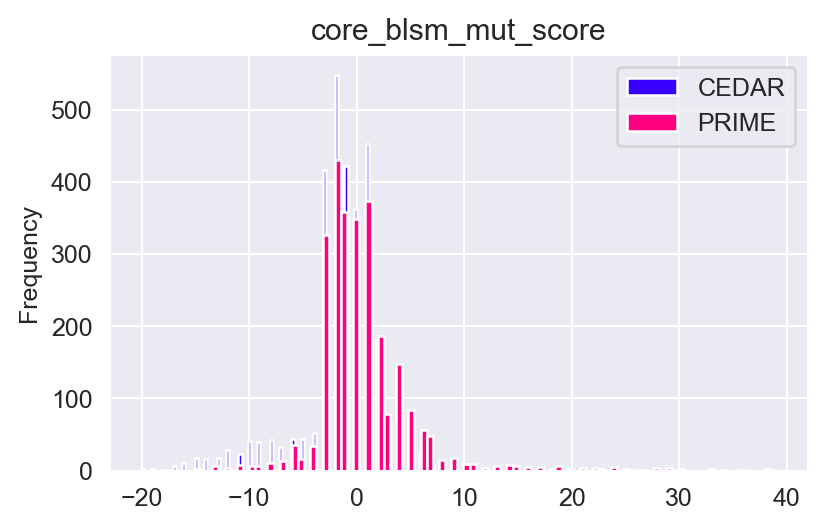

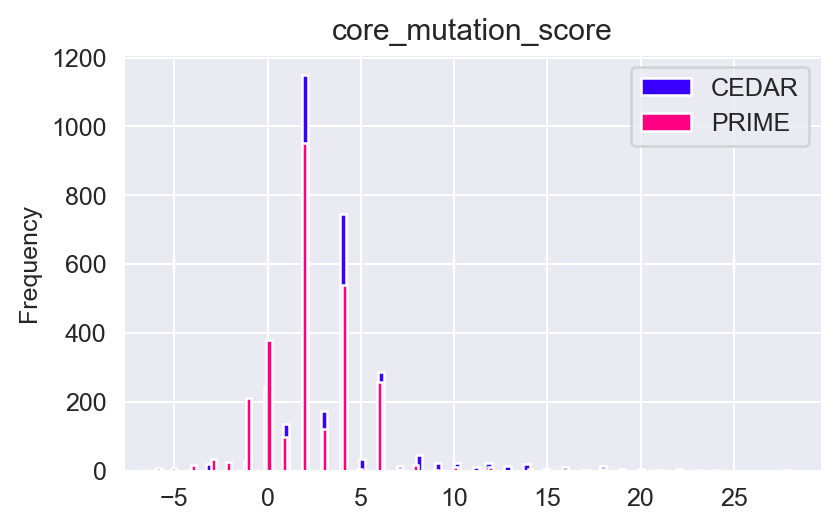

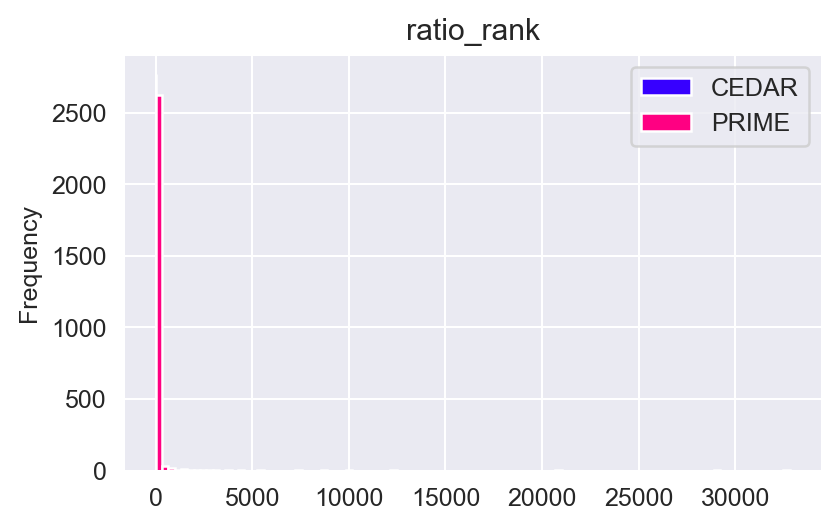

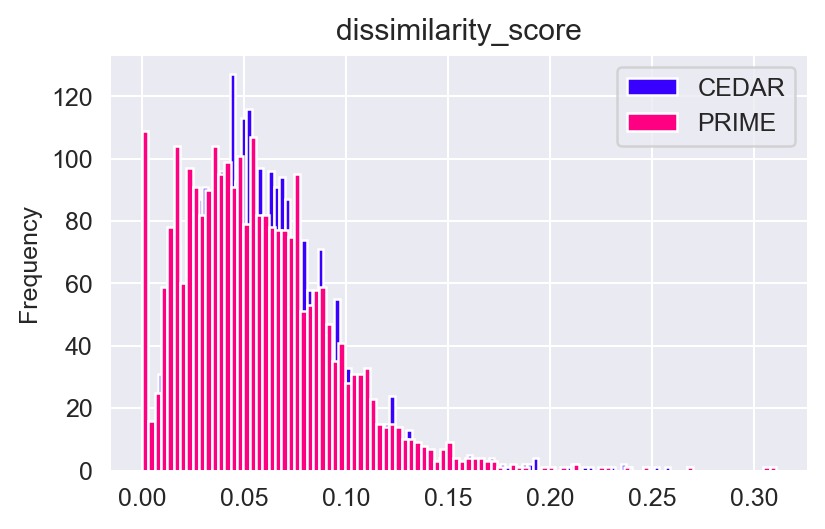

In [149]:
#TOP FOR top25_merged_primeac
#feats {'core_blsm_mut_score': 25, 'core_mutation_score': 16, 'ratio_rank': 25, 'dissimilarity_score': 7}
#weight {'(1-IC) KL': 2, '(1-IC) Mask': 1, '(1-IC) Shannon': 4, 'IC KL': 2, 'IC Mask': 7, 'IC Shannon': 4, 'None': 5}
for feat in {'core_blsm_mut_score': 25, 'core_mutation_score': 16, 'ratio_rank': 25, 'dissimilarity_score': 7}.keys():
    f,a = plt.subplots(1,1,figsize=(5,3))
    merged.groupby('dataset')[feat].plot(kind='hist', bins=100, legend=True)
    a.set_title(feat)
    

#### prime ast trainset ; check all evalsets

In [219]:
df_normal.loc[[('onehot', 'IC KL', 'Peptide', 'EL_rank_mut', 'aa_props', 'cedar')]][auc_cols]

,,,,,,mean_AUC_cedar,mean_AUC_prime,mean_AUC_ibel,mean_AUC_merged,mean_AUC_primeac,mean_AUC_agg
encoding,weight,pep_col,rank_col,key,trainset,,,,,,
onehot,IC KL,Peptide,EL_rank_mut,aa_props,cedar,0.727865,0.654859,0.538541,NaN,0.658181,0.691362


In [209]:
top25_prime_cedar_maskc = top25(df_maskc, 'prime_maskC', 'cedar')[auc_cols]
top25_prime_prime_maskc = top25(df_maskc, 'prime_maskC', 'prime')[auc_cols]
top25_prime_ibel_maskc = top25(df_maskc, 'prime_maskC', 'ibel')[auc_cols]
top25_prime_agg_maskc = top25(df_maskc, 'prime_maskC', 'agg')[auc_cols]
top25_prime_primeac_maskc = top25(df_maskc, 'prime_maskC', 'primeac')[auc_cols]

name_prime_cedar_maskc = get_topname(top25_prime_cedar_maskc)
name_prime_prime_maskc = get_topname(top25_prime_prime_maskc)
name_prime_ibel_maskc = get_topname(top25_prime_ibel_maskc)
name_prime_agg_maskc = get_topname(top25_prime_agg_maskc)
name_prime_primeac_maskc = get_topname(top25_prime_primeac_maskc)

In [210]:
print('\n\n\nTOP FOR top25_prime_cedar')
feat_top25_prime_cedar_maskc, weight_top25_prime_cedar_maskc = get_count(top25_prime_cedar_maskc, 'cedar')
display_top(top25_prime_cedar_maskc, 5)

print('\n\n\nTOP FOR top25_prime_prime')
feat_top25_prime_prime_maskc, weight_top25_prime_prime_maskc = get_count(top25_prime_prime_maskc, 'prime')
display_top(top25_prime_prime_maskc, 5)

print('\n\n\nTOP FOR top25_prime_ibel')
feat_top25_prime_ibel_maskc, weight_top25_prime_ibel_maskc = get_count(top25_prime_ibel_maskc, 'ibel')
display_top(top25_prime_ibel_maskc, 5)



print('\n\n\nTOP FOR top25_prime_primeac')
feat_top25_prime_primeac_maskc, weight_top25_prime_primeac_maskc = get_count(top25_prime_primeac_maskc, 'primeac')
display_top(top25_prime_primeac_maskc, 5)

print('\n\n\nTOP FOR top25_prime_agg')
feat_top25_prime_agg_maskc, weight_top25_prime_agg_maskc = get_count(top25_prime_agg_maskc, 'agg')
display_top(top25_prime_agg_maskc, 5)





TOP FOR top25_prime_cedar
feats {'blsm_mut_score': 17, 'mutation_score': 9, 'ratio_rank': 11, 'dissimilarity_score': 17, 'core_blsm_mut_score': 3, 'core_mutation_score': 1}
weight {'(1-IC) Mask': 25}





TOP FOR top25_prime_prime
feats {'blsm_mut_score': 9, 'mutation_score': 11, 'ratio_rank': 18, 'core_blsm_mut_score': 7, 'core_mutation_score': 6, 'dissimilarity_score': 7}
weight {'(1-IC) KL': 3, '(1-IC) Mask': 21, 'None': 1}





TOP FOR top25_prime_ibel
feats {'core_blsm_mut_score': 19, 'core_mutation_score': 14, 'ratio_rank': 9, 'dissimilarity_score': 11, 'blsm_mut_score': 1}
weight {'(1-IC) KL': 9, '(1-IC) Mask': 9, '(1-IC) Shannon': 7}





TOP FOR top25_prime_primeac
feats {'aa_props': 1, 'blsm_mut_score': 11, 'mutation_score': 17, 'ratio_rank': 10, 'core_blsm_mut_score': 2, 'core_mutation_score': 1, 'dissimilarity_score': 9, 'only_rank': 1}
weight {'(1-IC) Mask': 12, 'IC Mask': 6, 'None': 7}





TOP FOR top25_prime_agg
feats {'blsm_mut_score': 15, 'mutation_score': 12, 'ratio_rank': 14, 'core_blsm_mut_score': 3, 'core_mutation_score': 2, 'dissimilarity_score': 11}
weight {'(1-IC) Mask': 25}


## BOX PLOTS of best train best evals

In [287]:
xd_name_cedar_cedar = get_topname_parse(top25_cedar_cedar)
xd_name_cedar_prime = get_topname_parse(top25_cedar_prime)
xd_name_cedar_ibel = get_topname_parse(top25_cedar_ibel)
xd_name_cedar_agg = get_topname_parse(top25_cedar_agg)
xd_name_cedar_primeac = get_topname_parse(top25_cedar_primeac)
xd_name_merged_cedar = get_topname_parse(top25_merged_cedar)
xd_name_merged_prime = get_topname_parse(top25_merged_prime)
xd_name_merged_merged = get_topname_parse(top25_merged_merged)
xd_name_merged_ibel = get_topname_parse(top25_merged_ibel)
xd_name_merged_agg = get_topname_parse(top25_merged_agg)
xd_name_merged_primeac = get_topname_parse(top25_merged_primeac)
xd_name_prime_cedar = get_topname_parse(top25_prime_cedar)
xd_name_prime_prime = get_topname_parse(top25_prime_prime)
xd_name_prime_ibel = get_topname_parse(top25_prime_ibel)
xd_name_prime_agg = get_topname_parse(top25_prime_agg)
xd_name_prime_primeac = get_topname_parse(top25_prime_primeac)
xd_name_cedar_cedar_maskc = get_topname_parse(top25_cedar_cedar_maskc)
xd_name_cedar_prime_maskc = get_topname_parse(top25_cedar_prime_maskc)
xd_name_cedar_ibel_maskc = get_topname_parse(top25_cedar_ibel_maskc)
xd_name_cedar_agg_maskc = get_topname_parse(top25_cedar_agg_maskc)
xd_name_cedar_primeac_maskc = get_topname_parse(top25_cedar_primeac_maskc)
xd_name_merged_cedar_maskc = get_topname_parse(top25_merged_cedar_maskc)
xd_name_merged_prime_maskc = get_topname_parse(top25_merged_prime_maskc)
xd_name_merged_merged_maskc = get_topname_parse(top25_merged_merged_maskc)
xd_name_merged_ibel_maskc = get_topname_parse(top25_merged_ibel_maskc)
xd_name_merged_agg_maskc = get_topname_parse(top25_merged_agg_maskc)
xd_name_merged_primeac_maskc = get_topname_parse(top25_merged_primeac_maskc)
xd_name_prime_cedar_maskc = get_topname_parse(top25_prime_cedar_maskc)
xd_name_prime_prime_maskc = get_topname_parse(top25_prime_prime_maskc)
xd_name_prime_ibel_maskc = get_topname_parse(top25_prime_ibel_maskc)
xd_name_prime_agg_maskc = get_topname_parse(top25_prime_agg_maskc)
xd_name_prime_primeac_maskc = get_topname_parse(top25_prime_primeac_maskc)

In [273]:
df_total = pd.concat([df_normal, df_maskc]).reset_index('trainset')

In [268]:
def parsevarname(varname):
    x = varname.replace('name_','').split('_')
    trainset = x[0]
    evalset = x[1]
    if x[-1]=='maskc':
        trainset = trainset+'_maskC'
    return trainset, evalset

def get_cdt(var):
    var

In [345]:
filtered_df = []
for varname in [x for x in locals().keys() if 'xd_name' in x and not x.startswith('_')]:
    trainset, evalset = parsevarname(varname.replace('xd_', ''))
    filtered_df.append(df_total.query('trainset==@trainset').loc[[tuple(locals()[varname].split('XX'))]].assign(bestCdtFor=evalset))
filtered_df = pd.concat(filtered_df)
filtered_df=filtered_df[['trainset','bestCdtFor'] + list(filtered_df.columns.difference(['trainset','bestCdtFor']))]

In [421]:
filtered_df.query('bestCdtFor=="cedar"')

trainset  \
encoding weight      pep_col   rank_col    key                                                
onehot   IC KL       Peptide   EL_rank_mut aa_props                                   cedar   
                                           aa_props                                  merged   
         (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score         prime   
         IC Shannon  icore_mut EL_rank_mut aa_props                             cedar_maskC   
                                           aa_props                            merged_maskC   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                       prime_maskC   

                                                                              bestCdtFor  \
encoding weight      pep_col   rank_col    key                                             
onehot   IC KL       Peptide   EL_rank_mut aa_props                                cedar   
                                           aa_props                                cedar   
         (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score      cedar   
         IC Shannon  icore_mut EL_rank_mut aa_props                                cedar   
                                           aa_props                                cedar   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                          cedar   

                                                                               max_AUC_cedar  \
encoding weight      pep_col   rank_col    key                                                 
onehot   IC KL       Peptide   EL_rank_mut aa_props                                 0.768095   
                                           aa_props                                 0.768046   
         (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score       0.692941   
         IC Shannon  icore_mut EL_rank_mut aa_props                                 0.763220   
                                           aa_props                                 0.762033   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                           0.698864   

                                                                               max_AUC_ibel  \
encoding weight      pep_col   rank_col    key                                                
onehot   IC KL       Peptide   EL_rank_mut aa_props                                0.796286   
                                           aa_props                                0.779167   
         (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score      0.800000   
         IC Shannon  icore_mut EL_rank_mut aa_props                                0.816034   
                                           aa_props                                0.838819   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                          0.813095   

                                                                               max_AUC_merged  \
encoding weight      pep_col   rank_col    key                                                  
onehot   IC KL       Peptide   EL_rank_mut aa_props                                       NaN   
                                           aa_props                                  0.769743   
         (1-IC) Mask icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score             NaN   
         IC Shannon  icore_mut EL_rank_mut aa_props                                       NaN   
                                           aa_props                                  0.766282   
         (1-IC) Mask icore_mut EL_rank_mut blsm_mut_score                                 NaN   

                                                                               max_AUC_prime  \
encoding weight      pep_col   rank_col    key                                                 
onehot   IC KL       Peptide   EL_rank_mut aa_props                                 0.

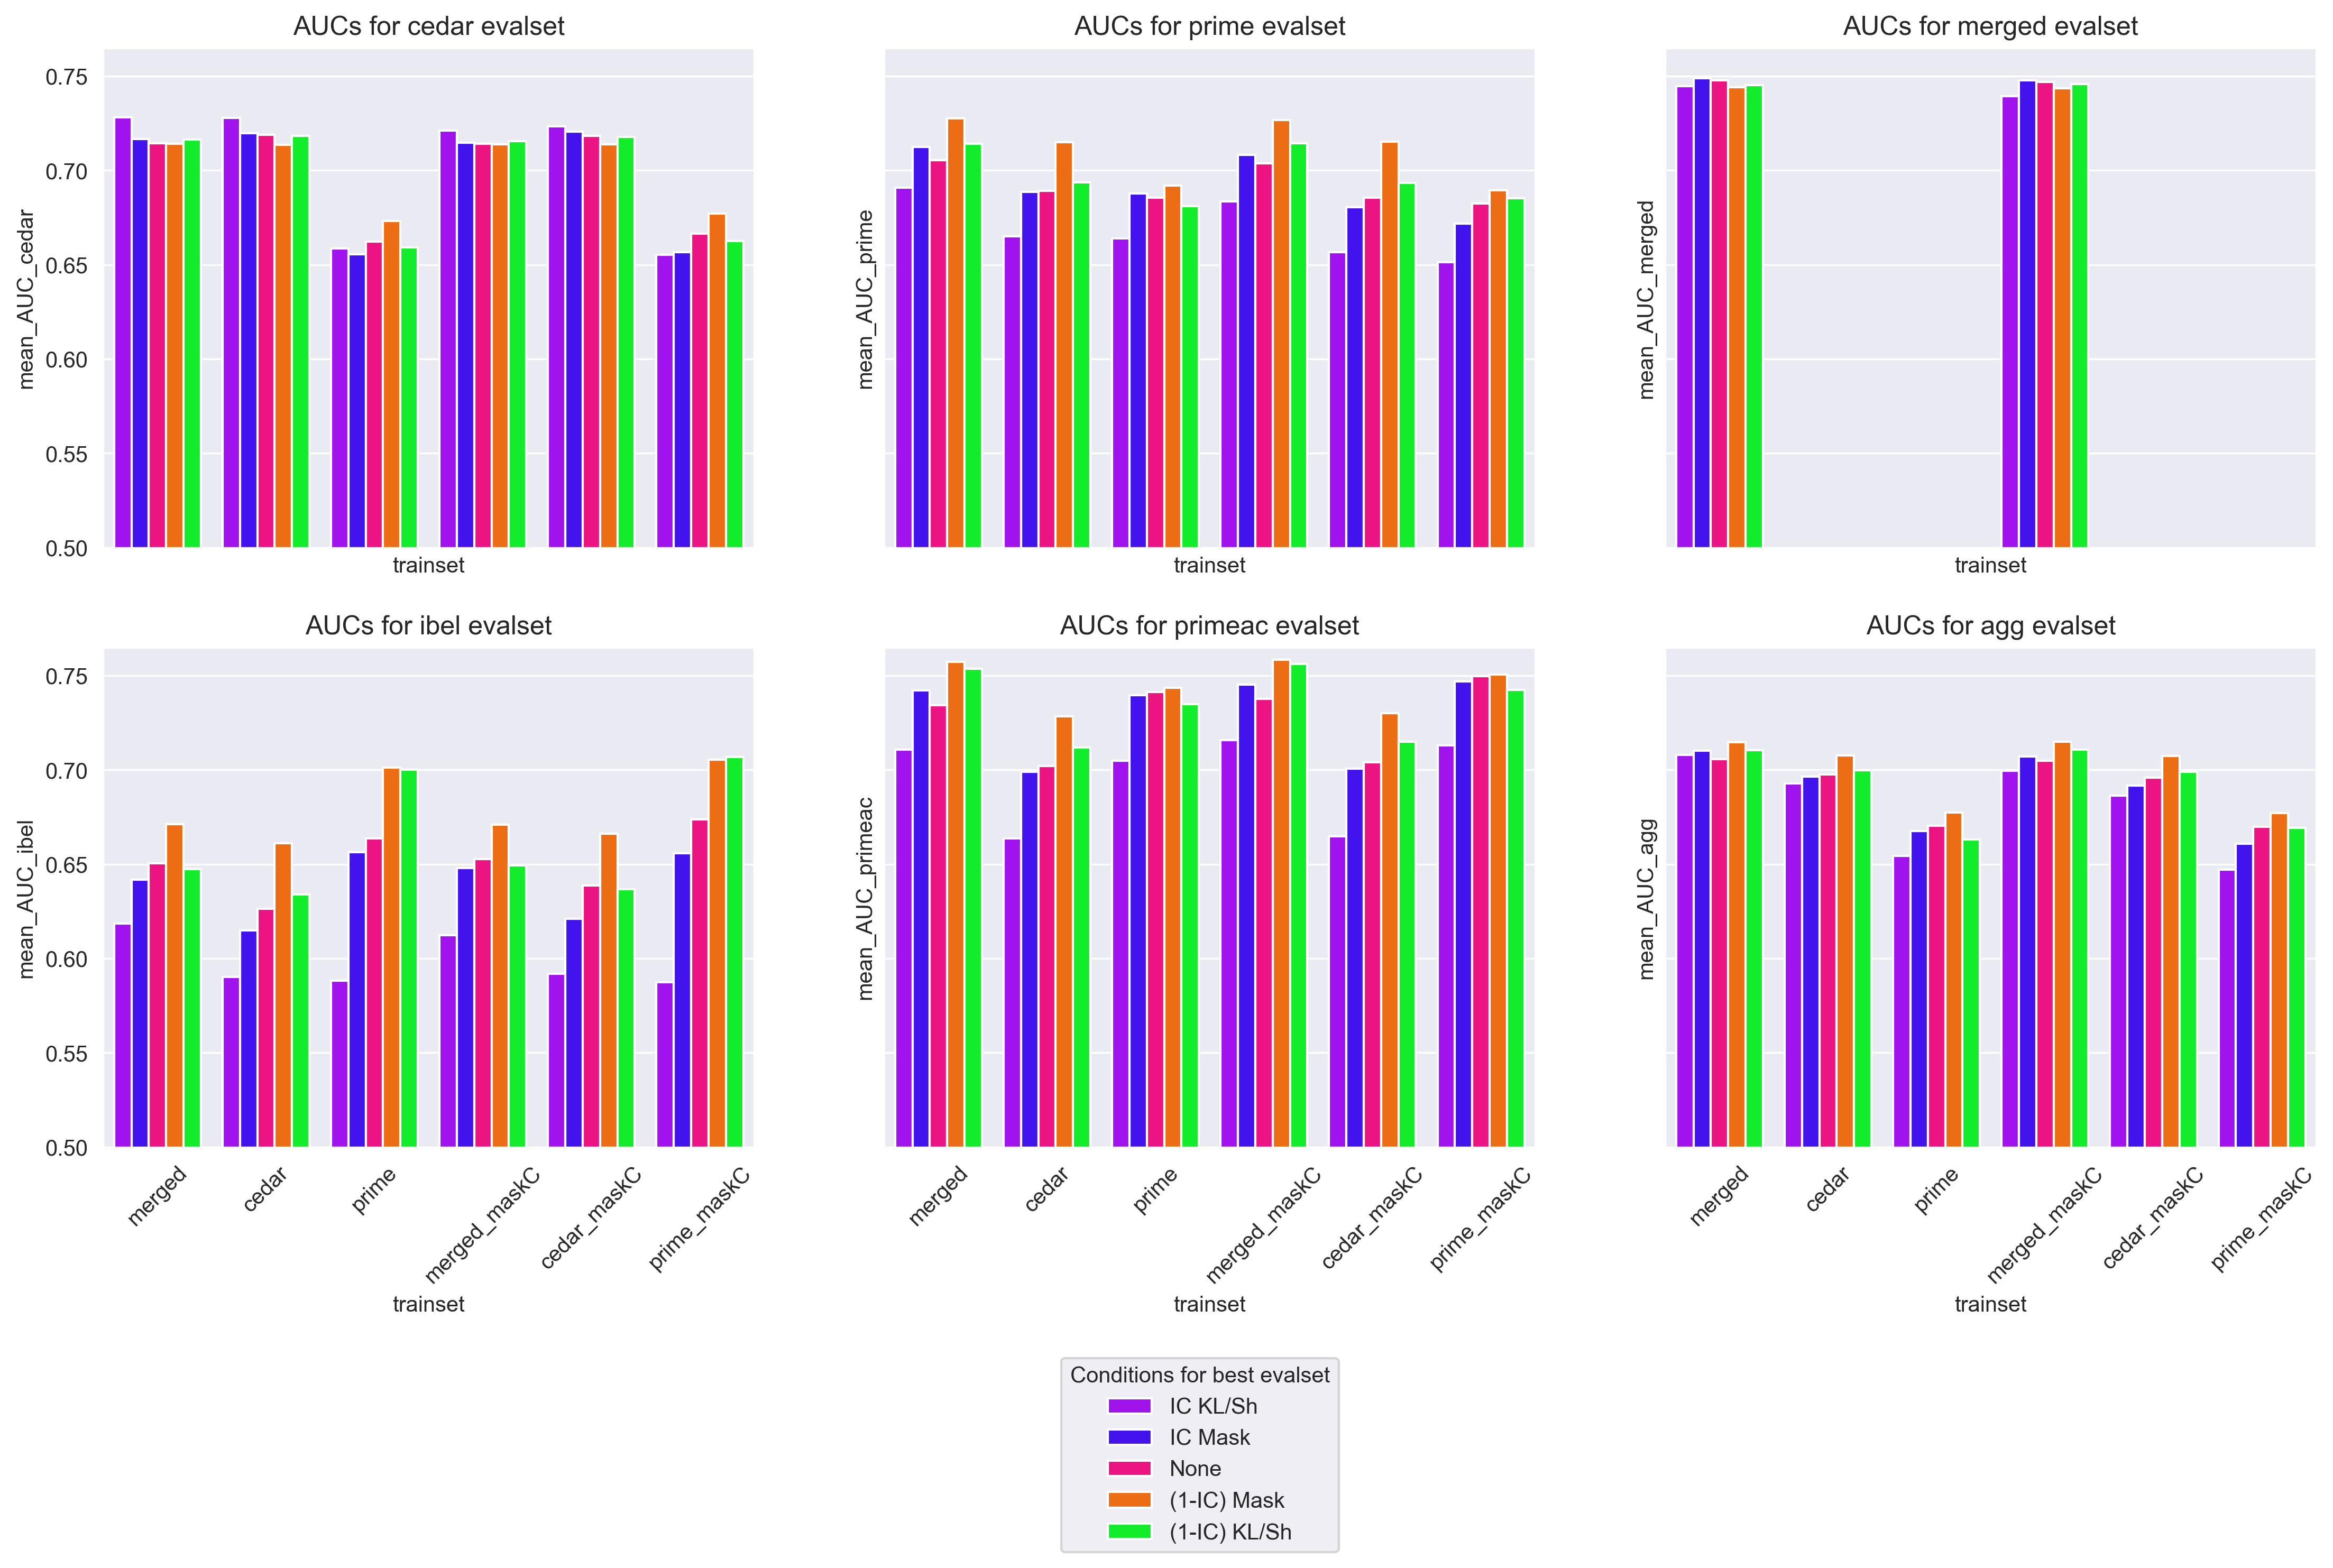

In [506]:
def rename_weight(weight):
    if 'KL' in weight:
        return weight.replace('KL', 'KL/Sh')
    elif 'Shannon' in weight:
        return weight.replace('Shannon', 'KL/Sh')
    else:
        return weight
    
f,a=plt.subplots(2,3, figsize=(18,9), sharex=True, sharey=True)
a = a.ravel()
tmp = df_total.reset_index('weight').copy()
tmp['weight'] = tmp['weight'].apply(rename_weight)
hue_order = ['IC KL/Sh', 'IC Mask', 'None', '(1-IC) Mask', '(1-IC) KL/Sh']

for i, eval_ in enumerate(['cedar', 'prime','merged', 'ibel', 'primeac', 'agg']):
    sns.set_palette([sns.color_palette('hsv',n_colors=13)[10]]+HSV)
    a[i].set_ylim([.5, .765])
    if eval_ == 'merged':
        a[i].set_xticks([0,3])
        a[i].set_xticklabels(['merged', 'merged_maskC'])
    sns.barplot(data= tmp, x='trainset', hue = 'weight', y=f'mean_AUC_{eval_}', ax=a[i], estimator='max', 
                saturation=.85, errorbar=None, hue_order=hue_order)
    if i < 5:
        a[i].get_legend().remove()
    else:
        a[i].legend(title='Conditions for best evalset', bbox_to_anchor=(-.485,-.4))
    a[i].set_title(f'AUCs for {eval_} evalset')
    a[i].set_xticklabels(a[i].get_xticklabels(), rotation=45, horizontalalignment='center')


In [521]:
output['AUC_change%']=output['AUC_change']*100
output[['AUC_change%']].describe(percentiles = np.arange(0,1.1,0.1))

,AUC_change%
count,30.000000
mean,3.460585
std,1.977209
min,-0.155670
0%,-0.155670
10%,1.248984
20%,1.760668
30%,2.020701
40%,2.933152
50%,3.205268


In [517]:
output = primeswitch_analysis.sort_values('AUC_change', ascending=False).reset_index(drop=True)                             
display(HTML(output.to_html(formatters={col: '{:,.2%}'.format for col in [x for x in primeswitch_analysis.columns if 'AUC' in x]})))

,weight,trainset,best_AUC_prime,best_AUC_primeSwitch,AUC_change
0,IC Mask,prime_maskC,67.17%,74.71%,7.53%
1,None,prime_maskC,68.25%,74.98%,6.73%
2,IC KL/Sh,prime_maskC,65.14%,71.31%,6.18%
3,(1-IC) Mask,prime_maskC,68.95%,75.06%,6.12%
4,(1-IC) KL/Sh,prime_maskC,68.52%,74.26%,5.74%
5,None,prime,68.55%,74.15%,5.60%
6,(1-IC) KL/Sh,prime,68.11%,73.48%,5.38%
7,IC Mask,prime,68.77%,73.96%,5.19%
8,(1-IC) Mask,prime,69.21%,74.36%,5.15%
9,(1-IC) KL/Sh,merged_maskC,71.45%,75.61%,4.16%


In [507]:
primeswitch_analysis = tmp.groupby(['weight','trainset']).agg(best_AUC_prime=('mean_AUC_prime','max'),
                                       best_AUC_primeSwitch=('mean_AUC_primeac','max')).reset_index()
primeswitch_analysis['AUC_change'] = primeswitch_analysis['best_AUC_primeSwitch']- primeswitch_analysis['best_AUC_prime']
primeswitch_analysis.sort_values('AUC_change')

,weight,trainset,best_AUC_prime,best_AUC_primeSwitch,AUC_change
12,IC KL/Sh,cedar,0.665215,0.663658,-0.001557
13,IC KL/Sh,cedar_maskC,0.656696,0.664749,0.008053
18,IC Mask,cedar,0.688546,0.699025,0.010479
24,None,cedar,0.689322,0.702035,0.012713
6,(1-IC) Mask,cedar,0.715089,0.728439,0.013350
7,(1-IC) Mask,cedar_maskC,0.715212,0.730116,0.014903
0,(1-IC) KL/Sh,cedar,0.693726,0.712009,0.018282
25,None,cedar_maskC,0.685635,0.704147,0.018512
14,IC KL/Sh,merged,0.690862,0.710835,0.019974
19,IC Mask,cedar_maskC,0.680468,0.700775,0.020307


,weight,trainset,best_AUC_prime,best_AUC_primeSwitch,AUC_change
0,(1-IC) KL/Sh,cedar,0.692304,0.711103,0.018798
1,(1-IC) KL/Sh,cedar_maskC,0.693326,0.714930,0.021604
2,(1-IC) KL/Sh,merged,0.713648,0.752575,0.038927
3,(1-IC) KL/Sh,merged_maskC,0.714491,0.756130,0.041639
4,(1-IC) KL/Sh,prime,0.681071,0.734270,0.053199
5,(1-IC) KL/Sh,prime_maskC,0.685155,0.741150,0.055995
6,(1-IC) KL/Sh/Sh,cedar,0.693726,0.712009,0.018282
7,(1-IC) KL/Sh/Sh,cedar_maskC,0.693350,0.714721,0.021372
8,(1-IC) KL/Sh/Sh,merged,0.714196,0.753730,0.039534
9,(1-IC) KL/Sh/Sh,merged_maskC,0.713566,0.755074,0.041508


In [331]:
filtered_df[['trainset','bestEval']+auc_cols]

trainset  \
encoding weight      pep_col   rank_col        key                                                                
onehot   IC KL       Peptide   EL_rank_mut     aa_props                                                   cedar   
         (1-IC) Mask Peptide   EL_rank_mut     core_blsm_mut_score-core_mutation_score                    cedar   
BL62LO   (1-IC) Mask Peptide   trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                    cedar   
onehot   (1-IC) Mask Peptide   EL_rank_mut     dissimilarity_score-core_blsm_mut_score-core_mu...         cedar   
                                               dissimilarity_score-core_blsm_mut_score-core_mu...         cedar   
         IC KL       Peptide   EL_rank_mut     aa_props                                                  merged   
         (1-IC) Mask Peptide   EL_rank_mut     dissimilarity_score-core_mutation_score                   merged   
         IC Mask     icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score-ratio_rank        merged   
BL62LO   (1-IC) Mask Peptide   trueHLA_EL_rank dissimilarity_score-blsm_mut_score                        merged   
onehot   (1-IC) Mask Peptide   EL_rank_mut     blsm_mut_score-mutation_score                             merged   
                                               dissimilarity_score-core_mutation_score                   merged   
                     icore_mut EL_rank_mut     dissimilarity_score-blsm_mut_score                         prime   
                     Peptide   EL_rank_mut     blsm_mut_score                                             prime   
BL62LO   (1-IC) Mask Peptide   trueHLA_EL_rank core_blsm_mut_score-core_mutation_score                    prime   
onehot   (1-IC) Mask Peptide   EL_rank_mut     blsm_mut_score                                             prime   
                                               dissimilarity_score-mutation_score-ratio_rank              prime   
         IC Shannon  icore_mut EL_rank_mut     aa_props                                             cedar_maskC   
         (1-IC) Mask Peptide   EL_rank_mut     core_blsm_mut_score-core_mutation_score              cedar_maskC   
BL62LO   (1-IC) Mask Peptide   trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score    cedar_maskC   
onehot   (1-IC) Mask Peptide   EL_rank_mut     core_blsm_mut_score-core_mutation_score              cedar_maskC   
                                               core_blsm_mut_score-core_mutation_score              cedar_maskC   
         IC Shannon  icore_mut EL_rank_mut     aa_props                                            merged_maskC   
         (1-IC) Mask Peptide   EL_rank_mut     dissimilarity_score-core_mutation_score             merged_maskC   
         IC Mask     icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score-ratio_rank  merged_maskC   
BL62LO   (1-IC) Mask Peptide   trueHLA_EL_rank dissimilarity_score-blsm_mut_score                  merged_maskC   
onehot   (1-IC) Mask Peptide   EL_rank_mut     blsm_mut_score-mutation_score                       merged_maskC   
                                               dissimilarity_score-core_mutation_score             merged_maskC   
                     icore_mut EL_rank_mut     blsm_mut_score                                       prime_maskC   
BL62LO   (1-IC) Mask Peptide   EL_rank_mut     core_blsm_mut_score-core_mutation_score-ratio_rank   prime_maskC   
         (1-IC) KL   Peptide   trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score              prime_maskC   
onehot   (1-IC) Mask Peptide   EL_rank_mut     blsm_mut_score-mutation_score-ratio_rank             prime_maskC   
                                               blsm_mut_score-mutation_score-ratio_rank             prime_maskC   

                                                                                                  bestEval  \
encoding weight      pep_col   rank_col        key                                

## Feat imps

In [522]:
from src.metrics import plot_feature_importance
trainsets = ['cedar', 'prime', 'merged', 'cedar_maskc',
cdt_dir = '../output/best_conditions/

## ROC plots